In [38]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D,GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

In [36]:
train_dir = 'data/Training'
val_dir = 'data/Testing'


In [39]:
# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [41]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=32,
    class_mode='binary'  # Use 'categorical' for multiple classes
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


### For EDA

In [4]:
X_train = []
y_train = []
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']


image_size = 150
for i in labels:
    folderPath = os.path.join('data/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('data/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 419.83it/s]


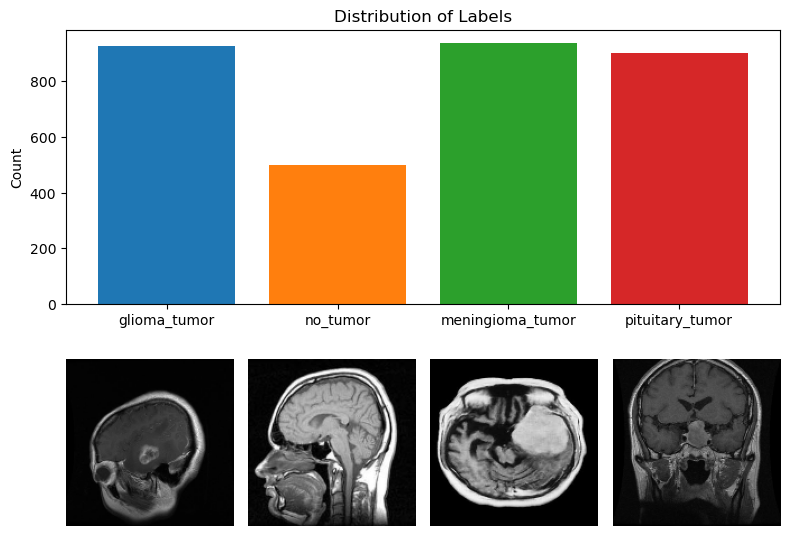

In [5]:
# Calculate the bar plot for each label
label_counts = {label: np.sum(y_train == label) for label in labels}

# Plot the bar plot and sample images in one chart
plt.figure(figsize=(8, 6))

colors = ["C0", "C1", "C2", "C3"]

# Plot the histogram
plt.subplot(2, 1, 1)
bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)
# plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Plot sample images from each label
k = 0
for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            plt.subplot(2, 4, k + 5) 
            plt.imshow(X_train[j])
            plt.axis('off')
            k += 1
            break
        j += 1
        
plt.tight_layout()
plt.show()

In [9]:
# Load the EfficientNetB0 model pretrained on ImageNet without the top layers
efficientnetB0 = tf.keras.applications.EfficientNetB0(weights='imagenet',
                                                      include_top=False,
                                                      input_shape=(image_size, image_size, 3))


# Build the custom model on top of the EfficientNetB0 base
model = efficientnetB0.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(1024,activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.4)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=efficientnetB0.input, outputs = model)


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2024-05-23 01:37:55.140688: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 01:37:55.209891: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 01:37:55.209940: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 01:37:55.212362: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 01:37:55.212426: I external/local_xla/xla/stream_executor

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 15s 1us/step


In [ ]:
model.summary()

In [11]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model 
checkpoint = ModelCheckpoint("efficientnetB0.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, 
                              min_delta=0.0001, verbose=1)

In [12]:
history = model.fit(train_generator, validation_data=validation_generator, epochs = 16, verbose = 1,
                    callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/16


I0000 00:00:1716446355.747173   50088 service.cc:145] XLA service 0x7fb1bc004530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716446355.747315   50088 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2024-05-23 01:39:16.266284: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-23 01:39:18.132592: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1716446366.241716   50726 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_21653', 84 bytes spill stores, 84 bytes spill loads

I0000 00:00:1716446366.249695   50730 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_21655', 40 bytes spill stores, 40 bytes spill load

82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7521 - loss: 0.6759

I0000 00:00:1716446409.296621   51145 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_21655', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1716446409.306131   51137 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_21653', 96 bytes spill stores, 96 bytes spill loads

I0000 00:00:1716446409.408058   51136 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_19772', 260 bytes spill stores, 260 bytes spill loads

I0000 00:00:1716446409.999431   51146 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_21655', 32 bytes spill stores, 32 bytes spill loads

I0000 00:00:1716446410.015206   51150 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_21655', 40 bytes spill stores, 40 bytes spill loads



83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.7531 - loss: 0.6736

I0000 00:00:1716446439.267948   51524 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2069', 224 bytes spill stores, 224 bytes spill loads

I0000 00:00:1716446441.669411   51574 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2062', 24 bytes spill stores, 24 bytes spill loads




Epoch 1: val_accuracy improved from -inf to 0.80272, saving model to efficientnetB0.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 106s 621ms/step - accuracy: 0.7541 - loss: 0.6714 - val_accuracy: 0.8027 - val_loss: 0.6351 - learning_rate: 0.0010
Epoch 2/16
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9235 - loss: 0.2339
Epoch 2: val_accuracy did not improve from 0.80272
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.9236 - loss: 0.2339 - val_accuracy: 0.7891 - val_loss: 0.7431 - learning_rate: 0.0010
Epoch 3/16
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9423 - loss: 0.1607
Epoch 3: val_accuracy improved from 0.80272 to 0.86054, saving model to efficientnetB0.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9425 - loss: 0.1606 - val_accuracy: 0.8605 - val_loss: 0.6349 - learning_rate: 0.0010
Epoch 4/16
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9629 - loss: 0.1180
Epoch 4: val_accuracy did not improve from 0.86054
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/s

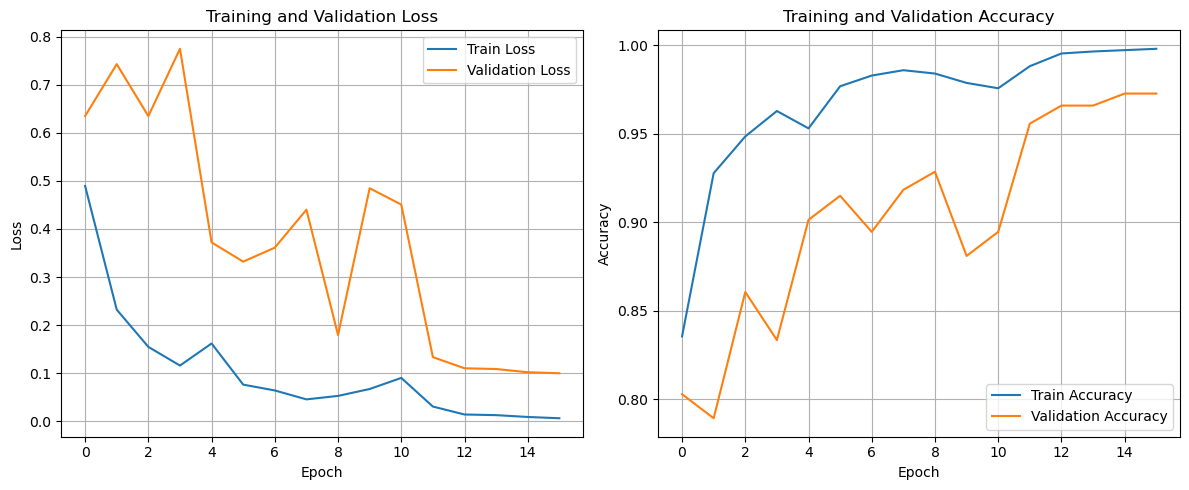

In [13]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1) 

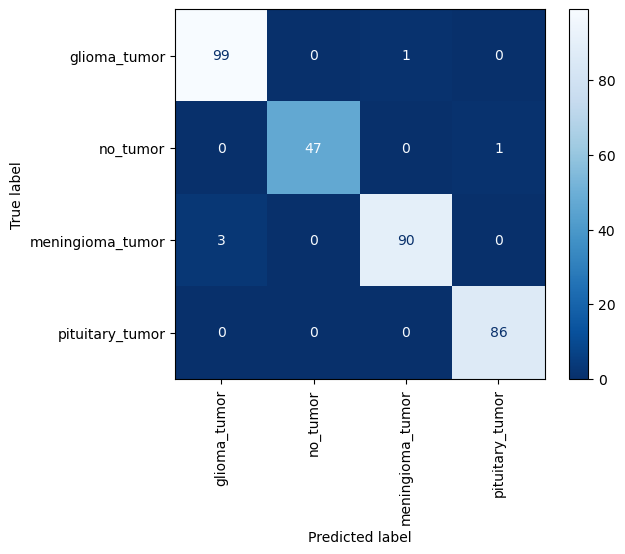

In [33]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true_test, y_pred_test), display_labels=labels).plot(cmap='Blues_r', xticks_rotation='vertical')

In [16]:
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       100
           1       1.00      0.98      0.99        48
           2       0.99      0.97      0.98        93
           3       0.99      1.00      0.99        86

    accuracy                           0.98       327
   macro avg       0.99      0.98      0.99       327
weighted avg       0.98      0.98      0.98       327



In [35]:
model.save("efficientnetB0_v1.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted label: glioma_tumor 
Actual label: glioma_tumor 
Confidence: 100.00%



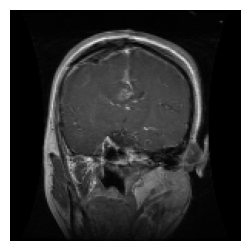

In [17]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]  
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)  
actual_label = labels[actual_class]  

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')  
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted label: no_tumor 
Actual label: no_tumor 
Confidence: 100.00%



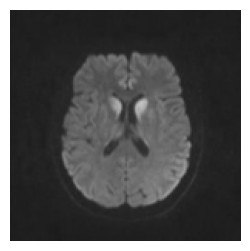

In [34]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]  
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)  
actual_label = labels[actual_class]  

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')  
plt.show()